# Generation of simulated High-Resolution Transmission Microscopy images of gold Nanoparticles and Column Heights label maps 

In this notebook it is demonstrated how to create simulated High-Resolution Transmission (HRTEM) images and the corresponding column heights (CHs) labels maps for training a neural network to predict the 3D configurarion of gold nanoparticles (NPs). The Python classes used to derive the NPs data (simulated HRTEM imahes and CHs labels) are implemented in the file '*make_NPs_data_utils.py*'. In particular, we will use the following classes:

 
 - **Random_NP**: generation of random gold NP model with random size in a given range.
 
 
 - **NP_HRTEM**: generation of the simulated HRTEM images from the precomputed NP atomic models.
 
 
 - **NP_Labels**: generation of the label maps of the CHs from the precomputed HEA atomic models.
 
 
 - **NP_Data**: saving the generated data (NP models, simulated HRTEM images and CHs maps) into numpy files.


A statistical analysis of the CHs distribution is also included. The class used to perform this task is implemented in the file '*make_statistics_NPs_utils.py*'. In particular:

  - **CHs_Distribution**: calculation of the statistical distribution of the CHs. The class calculates how many columns of different CH are present in an image, as well as the number of images in the dataset with a certain amount of CHs.
  
  
In addition, we investigate the correlation between the pixel intensities in the HRTEM images and the CHs. For this goal, we use a class implemented in the '*make_statistics_NPs_utils.py*' file:

 - **I_CHs_Correlation**: calculation of the relationship between the pixel intensities in the simulated HRTEM images and the corresponding CHs for each chemical element.
  
We use the following Python libraries: **Numpy**, **Scikit-Image** for image processing, **Atomic Simulation Environment (ASE)** for atomistic modeling and **PyQSTEM** for STEM images simulations.

In [1]:
# Importing the general libraries

import numpy as np

from ase.visualize import view

from pyqstem import PyQSTEM

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# 1. Generation of simulated HRTEM images and CHs label maps

## 1.1 NP atomic models

The class **Random_HEA** is used to generate the atomic models of gold NP characterized by a random size given in input. The HEA models are built using appropriate modules of the **ASE** library. The input parameters are:

 - **crystal_structure**: crystal structure of the NP atomic model. In this application, we consider FCC solid solutions NPs. 
 
 
 - **material**: material to select in creating th atomic models. Here we use 'gold'.
 
 
 - **lc**: lattice constant. This parameter must be in agreement with the selected material, since the lattice constant is a physical property of materials. In the case of gold, lc is 4.065.
 
 
 - **random_size**: we generate NP with a random size, selected in a range in agreement with the NPs in the experimental images. In this way, the neural network will be trained on images representing NPs with the same size of the experimental measurements. For our application, we consider a range between 15 and 30 A. It should be noted that the bigger the NPs, the higher the computational effort. 
 
 
 - **spatial domain**: it is very important to train the neural network on images wich represent a physical domain with the same size of the experimental measurements, unless the applications of the network on experimental images will not work. In our applications, the represented spatial domain is 51.2 A.
 

In [2]:
# importing the library

from make_NPs_data_utils import Random_NP

import random

# defining the input parameters

crystal_structure = 'fcc'

material = 'Au'

lc = 4.065

random_size = random.uniform(15, 30)

spatial_domain = (51.2, 51.2)  # A


# creating the object random_NP of the class Random_NP

random_NP = Random_NP(crystal_structure, material, lc, random_size, spatial_domain)

# generating the NP model using the method 'get_model' of the Random_NP class
    
random_NP_model = random_NP.get_model()

In [3]:
# 2D view of the atomic model

view(random_NP_model)

In [5]:
# 3D view of the atomic model

view(random_NP_model,viewer = 'x3d')

## 1.2 Simulated HRTEM images

The class **NP_HRTEM** is used to generate the simulated HRTEM images using PyQSTEM library. The input parameters are:

- **qstem**: object of the class PyQSTEM in HRTEM mode. The qstem object contains all the modules necessary to simulate the HRTEM images.


- **random_NP_model**: atomic model of the random HEA structure generated by the Random_NP class.


- **image_size**: size of the simulated images. We consider 256 x 256 images. The experimental images are 512 x 512, but setting correctly the resolution allows to represent the same spatial domain of 51.2 x 51.2 [A].


- **resolution**: amount of A represented in 1 pixel [A/px]. The resolution is equal to the spatial_domain [A] divided by the size of the image [px]. Since we have a spatial domain of 51.2 x 51.2 [A] and an image size of 256 x 256 [px], the resolution is 51.2 A/256 px = 0.2 [A/px]. The experimental images are 512x512 px, thus the resolution over a spatial domain of 51.2 [A] is 0.1 [A/px]. It is essential to generate simulated images with a resolution which is scaled to image size, in order to preserve the same spatial dimensionality.

- **Microscope Parameters**: the microscope parameters define the simulated imaging conditions. The value of the parameters must be in agreement with the experimental conditions.


- **random_Cs**:  1st order aberration.


- **random_defocus**:  defocus [A].


- **random_focal_spread**: focal spread [A].


- **random_aberrations**: 3rd order aberration [um].


- **random_blur**: blur [/].


- **random_dose**: electron dose [e-/A^2].


- **random_MTF_param**: MTF parameters [/].



In [4]:
# importing the library

from make_NPs_data_utils import NP_HRTEM

# defining the input parameters

qstem = PyQSTEM('HRTEM')

image_size = (256, 256)  # px

resolution = spatial_domain[0] / image_size[0]  # [A/px]


# microscope parameters

random_Cs = random.uniform(-15e4, 15e4)

random_defocus = random.uniform(180,200)

random_focal_spread = random.uniform(20, 40)

random_a22 = random.uniform(0, 50)

random_phi22 = random.uniform(0, 2 * np.pi)

random_aberrations = {'a22': random_a22, 'phi22': random_phi22}

random_blur = random.uniform(0, 1)

random_dose = random.uniform(1e2, 1e3)

random_c1 = random.uniform(0.95, 1)

random_c2 = random.uniform(0, 1e-1)

random_c3 = random.uniform(5e-1, 6e-1)

random_c4 = random.uniform(2, 3)

random_MTF_param = [random_c1, random_c2, random_c3, random_c4]

In [5]:
# creating the object HEA_stem of the class HEA_STEM

NP_hrtem = NP_HRTEM(qstem,
                    random_NP_model,
                    image_size,
                    resolution,
                    random_Cs,
                    random_defocus,
                    random_focal_spread,
                    random_aberrations,
                    random_blur,
                    random_dose,
                    random_MTF_param)


# generating the simulated HAADF STEM image using the 'get_HEA_stem' method

img = NP_hrtem.get_HRTEM_img()

## 1.3 Column Heights Labels

The class **NP_Labels** is used to generate the column heights maps in the NP structure. The CHs maps are created with a Gaussian distribution centered in the column's peaks, to which it is assigned the value representing the number of atoms in the colum (i.e., CH), while the other pixel values decrease with continuity towards the background. The continuity of the pixel's values is essential for the implementation of a regression-based prediction of the CHs.


 - **random_NP_model**: NP atomic model generated with the Random_NP class.
 
 
 - **image_size**: the size of the label maps must be the same of the input image, since the deep learning model is a fully convolutional network (FCN) with a symmetrical structure of the encoder and decoder blocks.
 
 
 - **resolution**: the label maps must be created with the same resolution of the input image in order to preserve the represented spatial dimensionality.



In [6]:
# importing the library

from make_NPs_data_utils import NP_Labels

# creating the object HEA_labels of the class HEA_Labels

NP_labels = NP_Labels(random_NP_model,
                          image_size,
                          resolution)

# generating the CHs label maps for each chemical element
lbl = NP_labels.get_CHs_labels()

/opt/anaconda3/envs/tensorflow2.2_python3.7/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 1.4 Plots of the simulated HRTEM image and CHs label map

/opt/anaconda3/envs/tensorflow2.2_python3.7/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


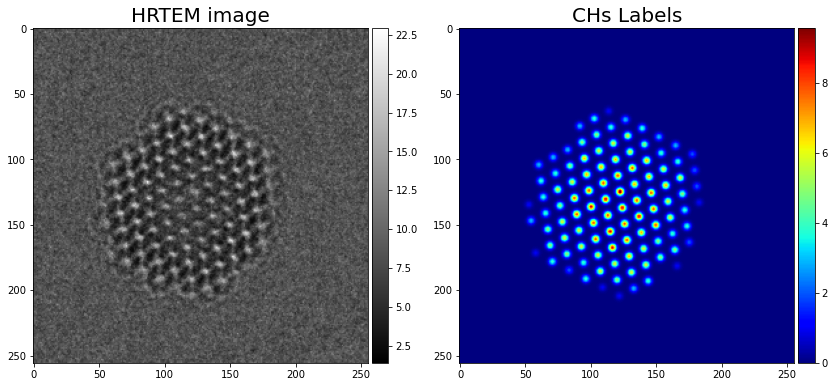

In [7]:
fig = plt.figure(figsize=(14, 7))

ax = fig.add_subplot(1, 2, 1)
im = ax.imshow(img, cmap='gray')
plt.title('HRTEM image', fontsize=20)
divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax1)


ax = fig.add_subplot(1, 2, 2)
im = ax.imshow(lbl, cmap='jet')
plt.title('CHs Labels', fontsize=20)
divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax1)



## 1.5 Saving the data

The class **NP_Data** is used to save the simulated data (i.e., simulated HRTEM image and CHs label map) into a training/test directory. Since the input image and the label maps have the same size, **they are concatenated into a single variable and saved into a single 4D numpy array (tensor) and labeled with the index 'data_index'. Saving 4D tensors allows the data to be ready for Deep Learning processing** . The input parameters are:


- **random_NP_model**: NP atomic model generated with the Random_NP class.


- **img**: simulated HRTEM image.


- **lbl**: CHs label map.


- **path**: path to the parent directory containing the saved files. The sub-directories will be:

  - **data**: directory containing the tensor data saved in the numpy files (.npy).
  
  - **models**: directory containing the saved NPs atomic models (.xyz).
  
  - **plots**: directory containing the plots of the simulated HRTEM image and the CHs label map.

In [8]:
# importing the library

from make_NPs_data_utils import NP_Data

# defining the input parameters.

path = 'training_data/' # training data directory.
#path = 'test_data/' # test data direcotry.


data_index = 1 # here we have only 1 data to save.

# creating the object HEA_data of the class HEA_Data.
NP_data = NP_Data(random_NP_model,
                      img,
                      lbl,
                      path,
                      data_index)

# saving the data using the 'save_HEA' method.
NP_data.save_NP()

/opt/anaconda3/envs/tensorflow2.2_python3.7/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 2. CHs statistical analysis

There are three statistical distributions to consider. First, we consider a distribution describing the number of images in the dataset with a certain amount of columns of a given CH (or fraction of columns with a given CH). Then, we calculate the distribution of the number of different CHs in a single image (or the fraction of different CHs in a single image). Finally, the third distributions is a combination of the first two.


The distributions are calculated using the **CHs_Distribution** class. Input parameters:

- **path**: path to the directory corresponding to the training data


- **ch_min,ch_max**: minumum and maximum CHs to consider in the calculation of the distribution. The minimum CH is 1 (i.e., 1 atom) and the maximum is set to 15 (i.e., 15 atoms). ch_max depends on the size of NP we want to consider.


The statistical analysis is conducted here on a **small dataset of few images in the directory 'training_data/'** for demonstration purpose. 

In [9]:
# importing the library 

from make_NPs_statistics_utils import CHs_Distribution

# defining the input parameters

path = 'training_data/'

n_elements = 1

ch_min = 0

ch_max = 15

# creating the object CHs_distr of the class CHs_Distribution

CHs_distr = CHs_Distribution(path,ch_min,ch_max)

/opt/anaconda3/envs/tensorflow2.2_python3.7/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 2.1 CHs distributions

The first and second CHs distributions are calculated using the **get_CHs_distribution** method. 

In [10]:
# applying the get_CHs_distribution() method

absolute_CHs_distribution, relative_CHs_distribution = CHs_distr.get_CHs_distribution()

/opt/anaconda3/envs/tensorflow2.2_python3.7/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 2.1.1 Distribution of the number of images with a certain amount of columns with a given CH

We are interested in a distribution which shows how many  images have a certain amount of columns with a CH of interest. In the example the CH of interest is 5. The distribution can be given in terms of number of columns, as well as in terms of fraction of columns. 

/opt/anaconda3/envs/tensorflow2.2_python3.7/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'CHs distribution')

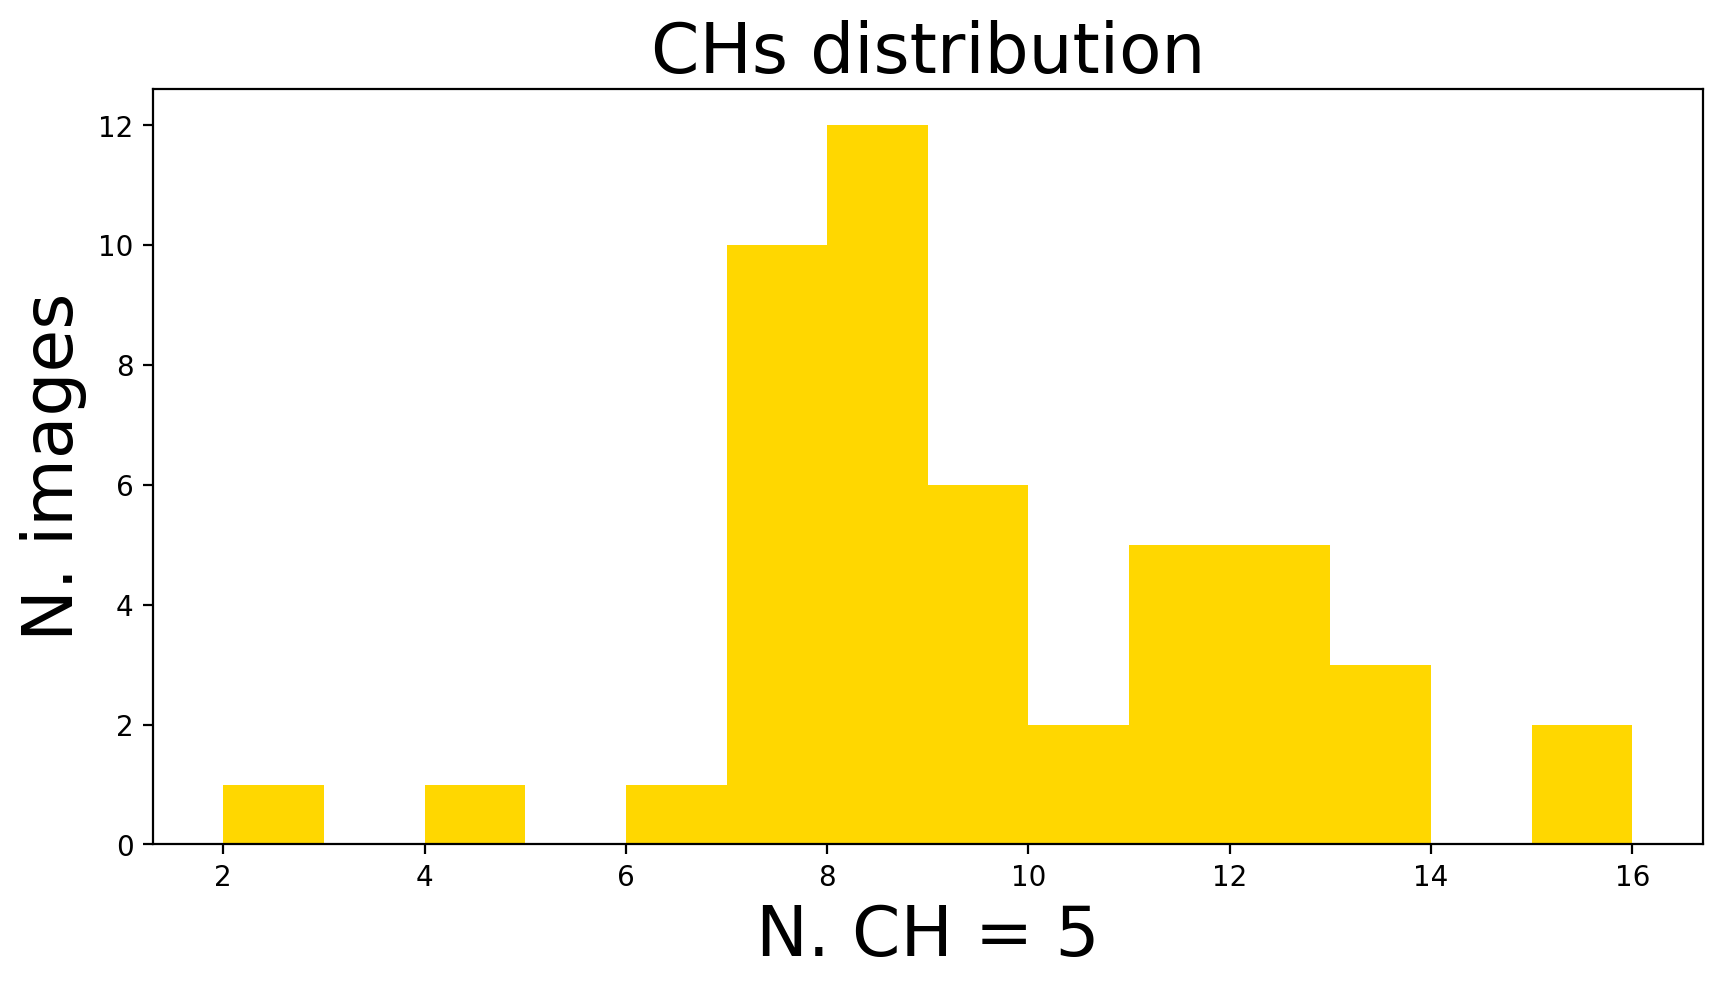

In [11]:
ch = 5



ce = 1
fig = plt.figure(figsize=(10,5),dpi = 200)


ax = fig.add_subplot(1,1,1)
ax.hist(absolute_CHs_distribution[ch -1],
        np.arange(min(absolute_CHs_distribution[ch -1]),
        max(absolute_CHs_distribution[ch -1] +1)),color = 'gold')

plt.xlabel('N. CH = {}'.format(ch),fontsize = 25)
plt.ylabel('N. images'.format(ch),fontsize = 25)
plt.title('CHs distribution',fontsize = 25)

/opt/anaconda3/envs/tensorflow2.2_python3.7/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'CHs distribution')

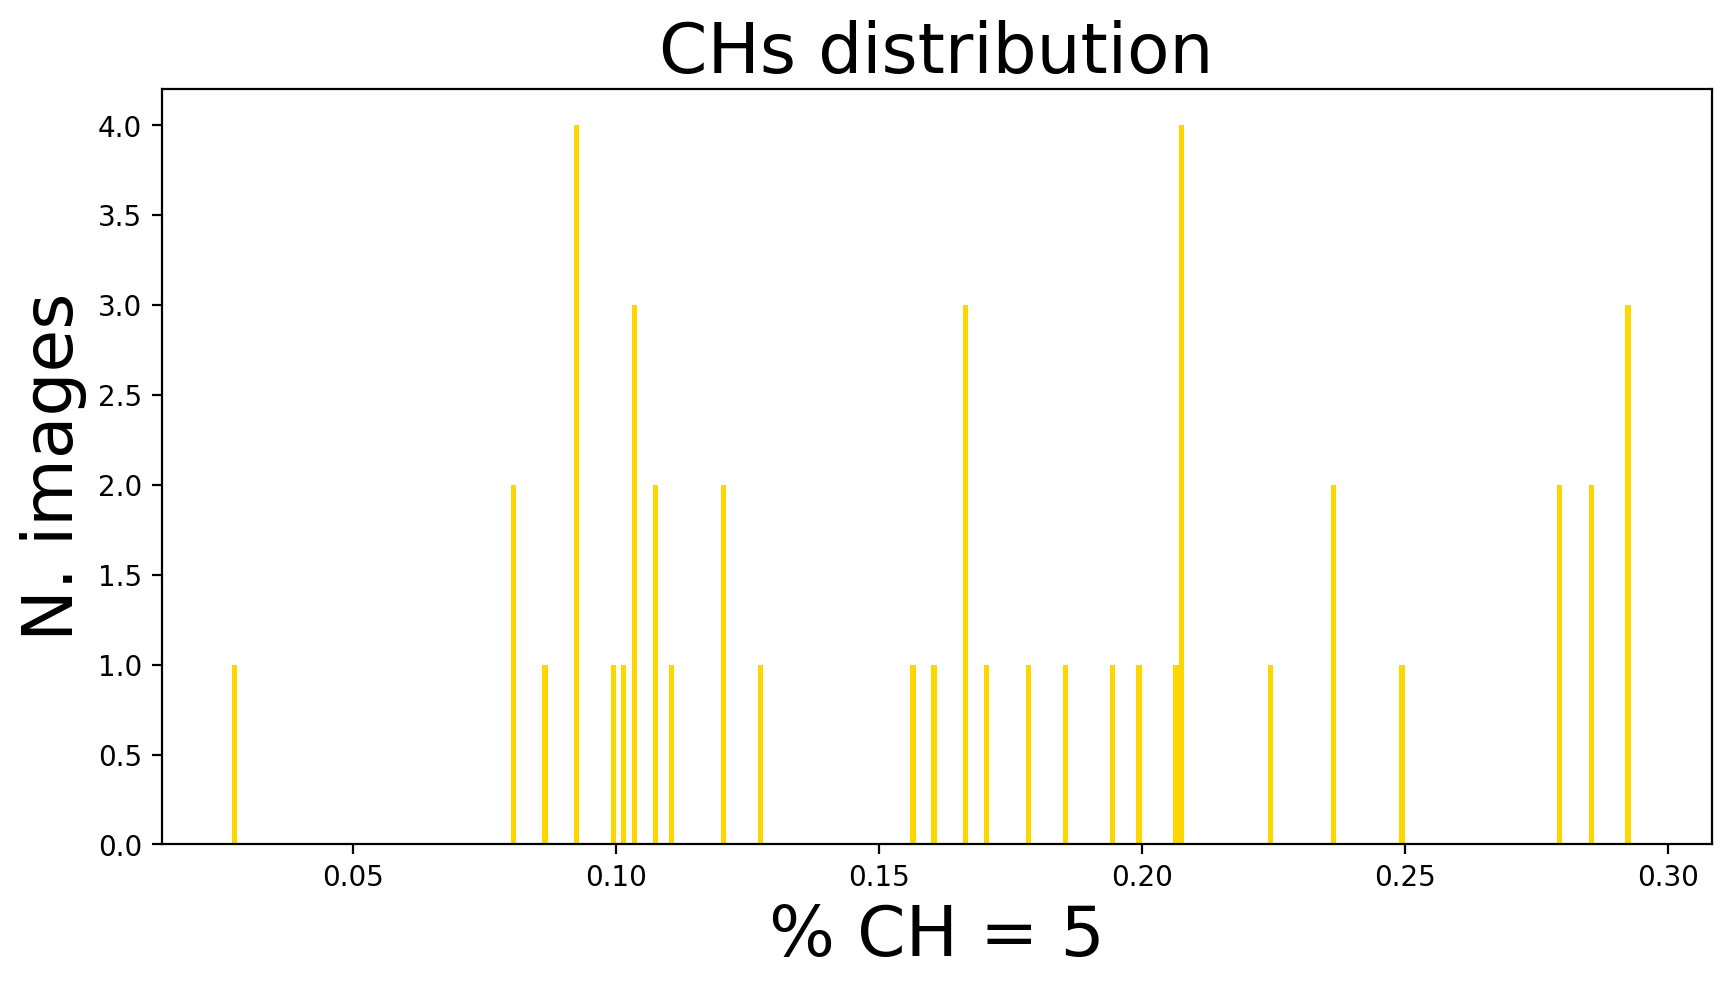

In [12]:
ch = 5


fig = plt.figure(figsize=(10,5),dpi = 200)


ax = fig.add_subplot(1,1,1)
ax.hist(relative_CHs_distribution[ch - 1],
np.arange(min(relative_CHs_distribution[ch - 1]),
        max(relative_CHs_distribution[ch - 1]), step = 0.001),color = 'gold')

plt.xlabel('% CH = {}'.format(ch),fontsize = 25)
plt.ylabel('N. images'.format(ch),fontsize = 25)
plt.title('CHs distribution',fontsize = 25)

### 2.1.2 Distribution of the amount of columns with different CHs in an image

We are interest in a distribution which shows the number of columns with different CHs in an image. The distribution can be given in terms of absolute number of columns, as well as a percentage of columns. The scatterplot below shows the number of columns with different CHs for the image with index 1.

/opt/anaconda3/envs/tensorflow2.2_python3.7/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'N. Columns')

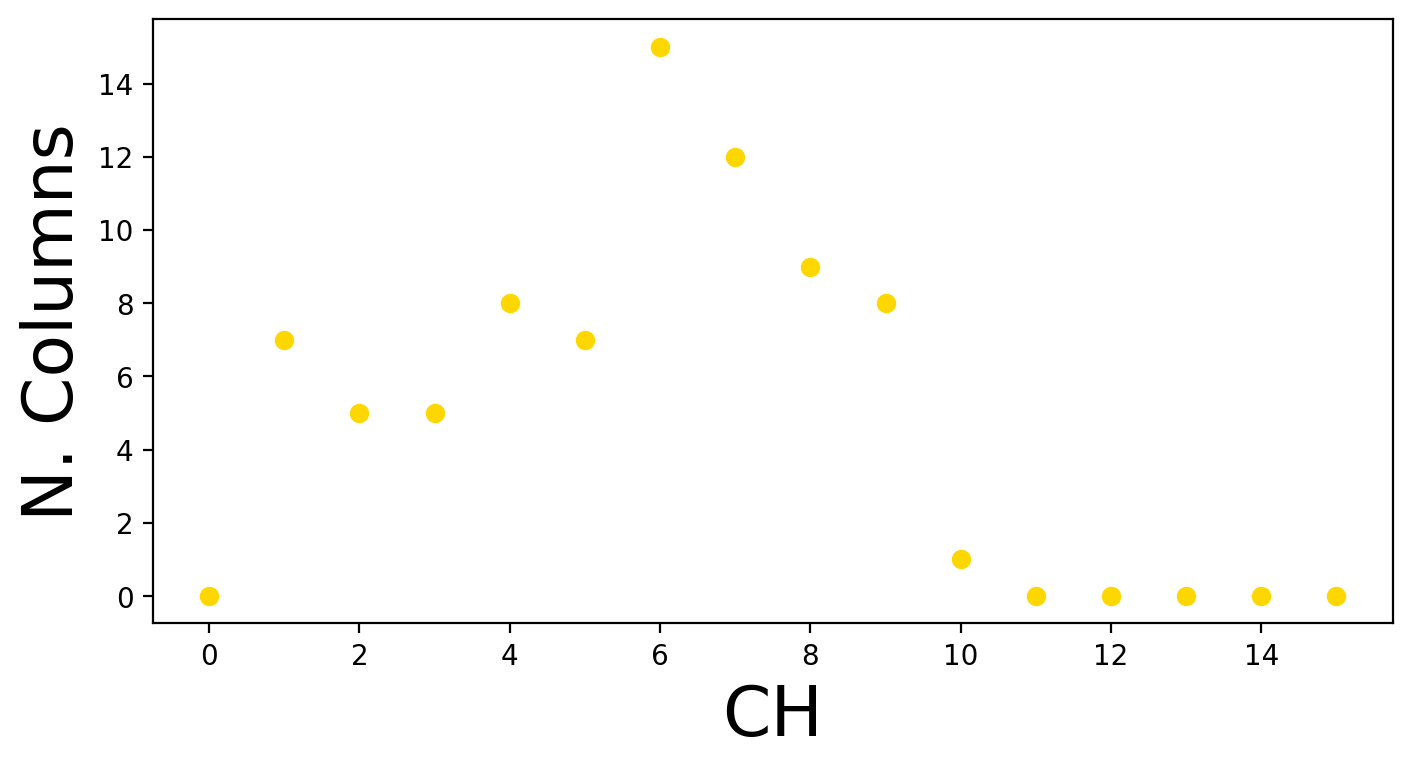

In [13]:
data_index = 1

fig = plt.figure(figsize=(8,4),dpi = 200)


plt.scatter(np.arange(ch_min,ch_max + 1),
            absolute_CHs_distribution[:,data_index],
            color = 'gold')
    
plt.xlabel('CH',fontsize = 25)
plt.ylabel('N. Columns',fontsize = 25)
 


/opt/anaconda3/envs/tensorflow2.2_python3.7/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'N. Columns')

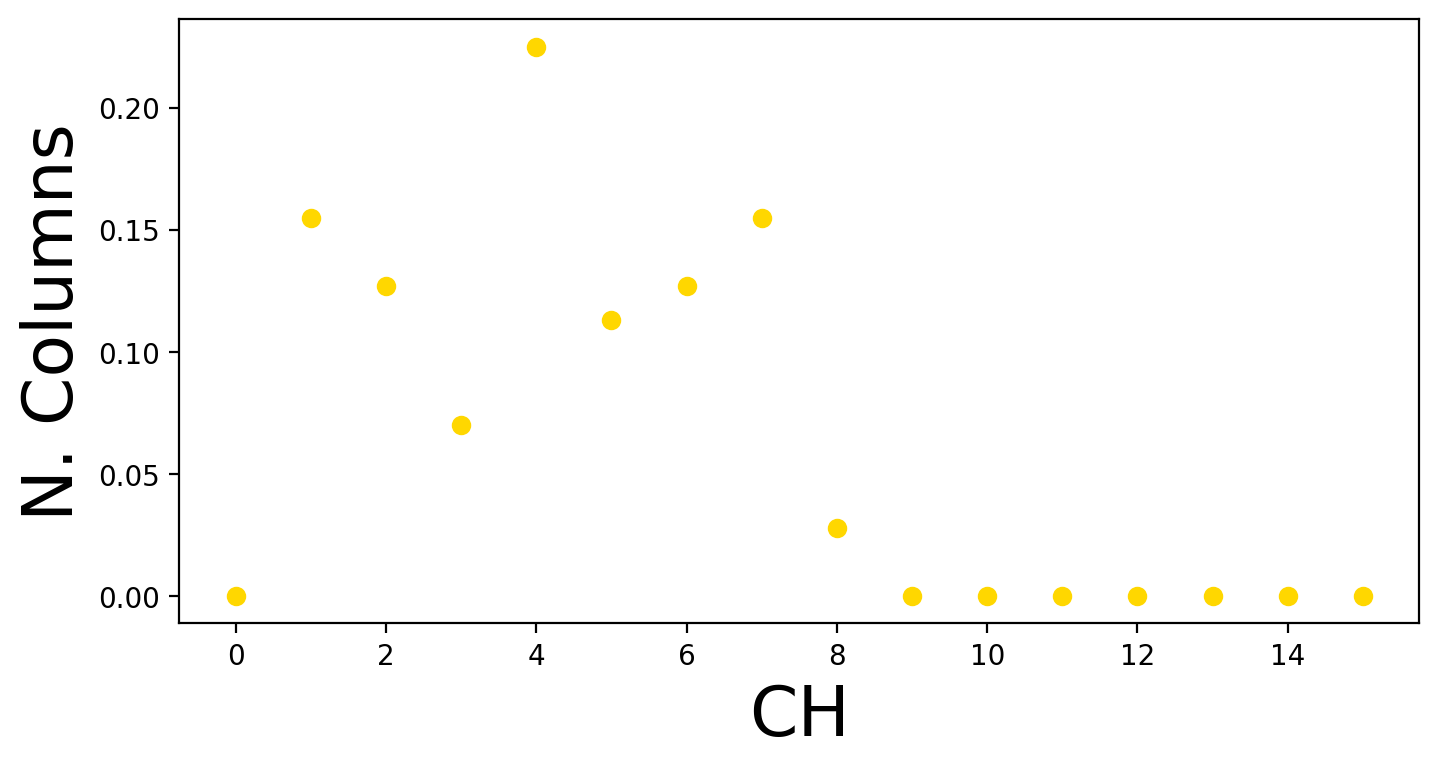

In [14]:
data_index = 3

fig = plt.figure(figsize=(8,4),dpi = 200)


plt.scatter(np.arange(ch_min,ch_max + 1),
            relative_CHs_distribution[:,data_index],
            color = 'gold')
    
plt.xlabel('CH',fontsize = 25)
plt.ylabel('N. Columns',fontsize = 25)


### 2.1.3 Box plots

The distributions in **2.1.1** and **2.2.2** can be combined in a box plot distribution.

/opt/anaconda3/envs/tensorflow2.2_python3.7/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'N. Columns')

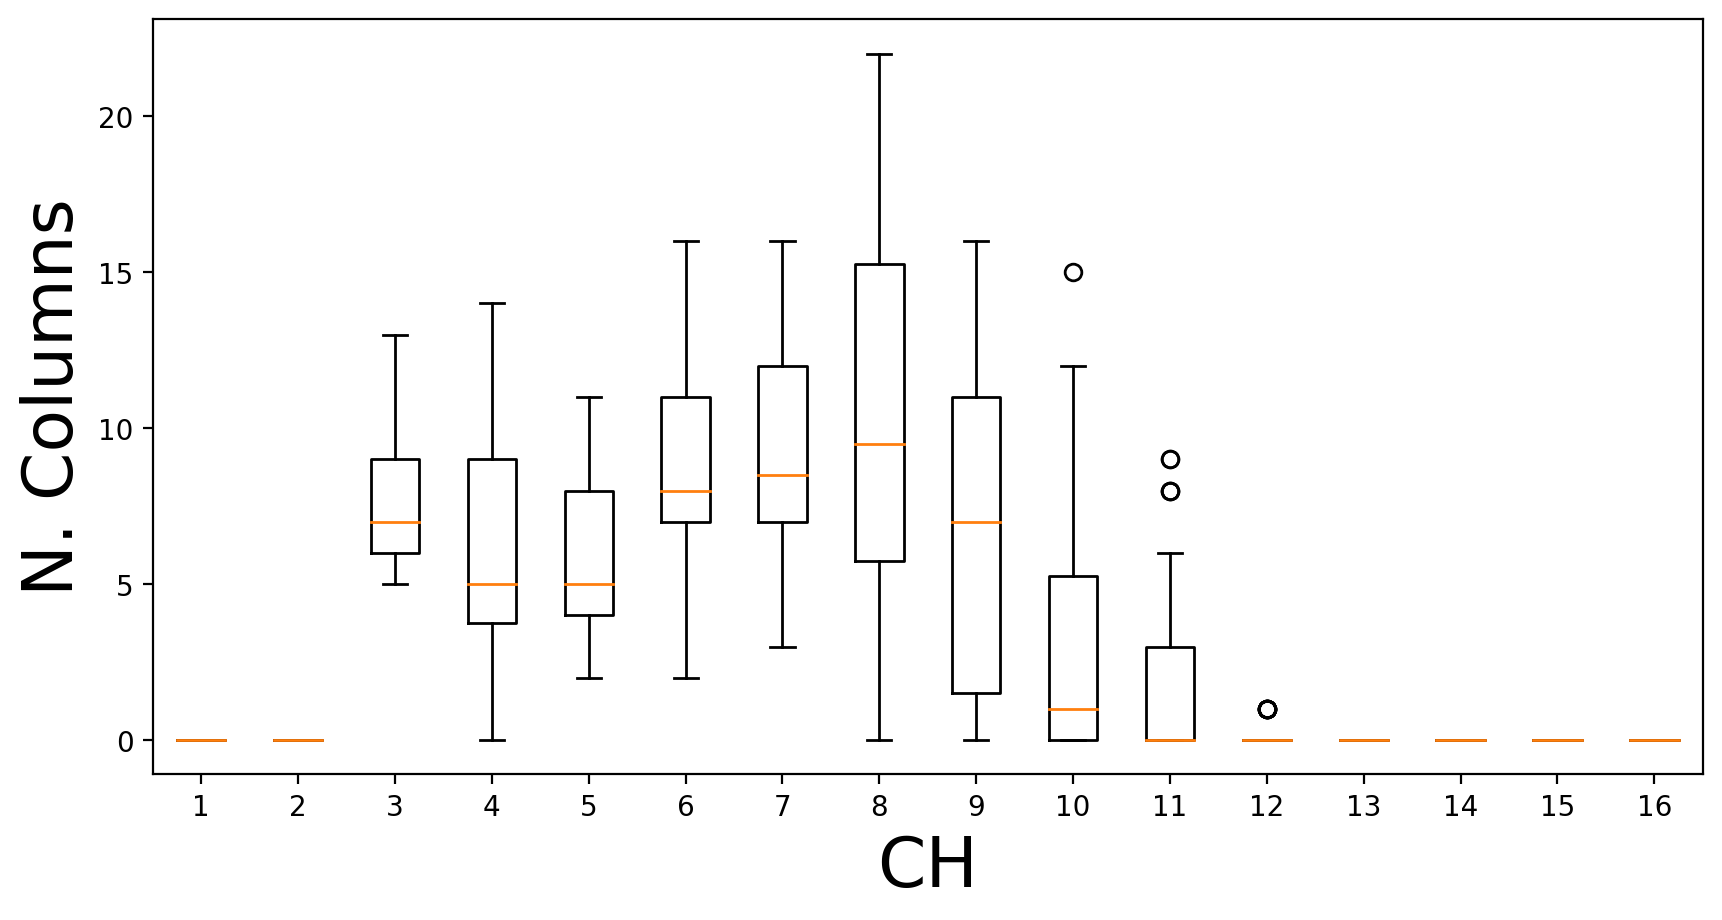

In [15]:
box_plot_distr = []

fig = plt.figure(figsize=(10,5),dpi = 200)

for ch in range(ch_min, ch_max + 1):
    
    box_plot_distr.append(absolute_CHs_distribution[ch -1])
        
ax = fig.add_subplot(1,1,1)
ax.boxplot(box_plot_distr)
    
plt.xlabel('CH',fontsize = 25)
plt.ylabel('N. Columns',fontsize = 25)
    

# 3. Correlation of HRTEM Pixels Intensity - CHs 

We study the correlations between the pixel intensities in the simulated HRTEM images and the CHs. For this task, we use the class **I_CHs_Correlation** and the corresponding **get_I_CHs_correlation()** method.

In [16]:
# importing the library 

from make_NPs_statistics_utils import I_CHs_Correlation

# definint the input parameters

path = 'training_data/'

# definint the object I_CHs_corr of the class I_CHs_Correlation

I_CHs_corr = I_CHs_Correlation(path)


# applying the get_I_CHs_correlation() method

I_CHs_correlation = I_CHs_corr.get_I_CHs_correlation()

/opt/anaconda3/envs/tensorflow2.2_python3.7/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The scatter-plot below shows that the correlations between the peaks intensities in the simulated HRTEM image and the CHs is highly non-linear, since the data cloud in the scatter-plot are highly dispersed.The objective of our Deep Learning model is to capture this non-linear correlation.

/opt/anaconda3/envs/tensorflow2.2_python3.7/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'I')

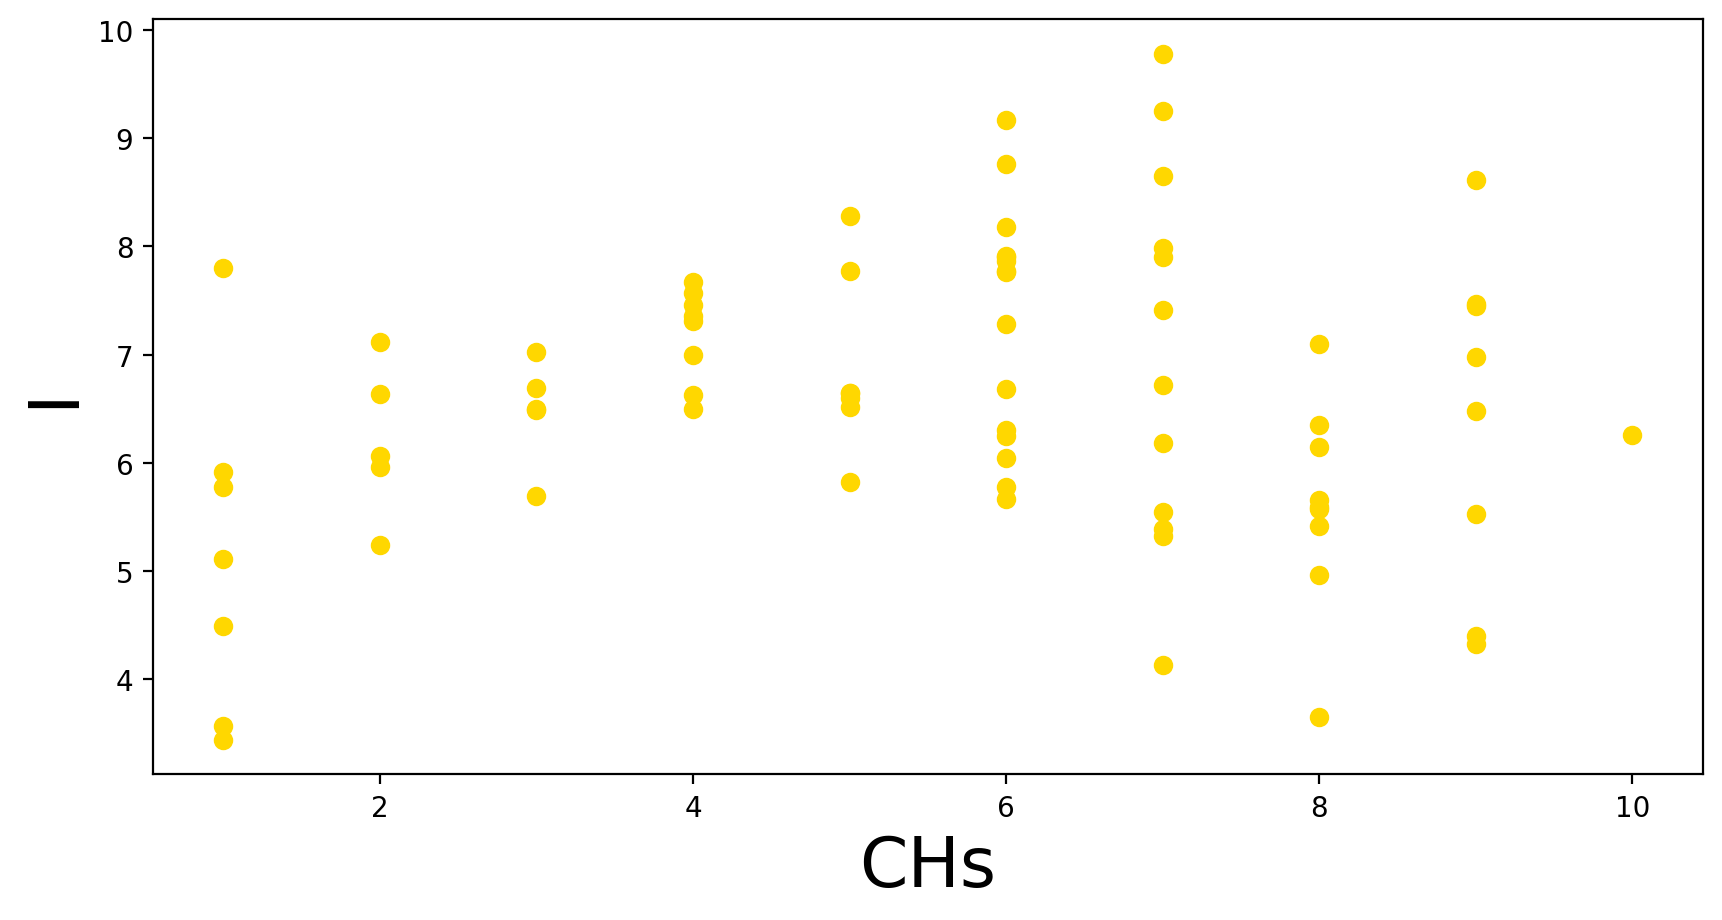

In [17]:
data_index = 1

fig = plt.figure(figsize=(10,5),dpi = 200)

ax = fig.add_subplot(1,1,1)
ax.scatter(I_CHs_correlation[data_index][:,0],
           I_CHs_correlation[data_index][:,1],
           c = 'gold')
    
plt.xlabel('CHs',fontsize = 25)
plt.ylabel('I',fontsize = 25)

    
    